In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

#MPI
from schwimmbad import MPIPool

#General packages
import numpy as np
import emcee
import matplotlib.pyplot as plt

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.constants import G, M_sun, c
import astropy.units as u

#Autolens Model packages
import autolens as al
import autolens.plot as aplt

#My Emcee for Pyautolens
import My_Autolens

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_5/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component

## Models inicialization

"""
    To inicialize the model, we set some random values for the parameters. But it's only necessary for initialize the model. During the non-linear search, this values will be updated constantly until the best fit.
"""  
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
ml     = 7.00                                                          #mass to light ratio
r_s    = 11.5                                                          #scale radius [arcsec]
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear


#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile
mass_profile = al.mp.MGE()    #Mass class

ell_comps    = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW         = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps ,scale_radius=r_s) #Analytical eNFW profile


#Components
#Do not include MGE DM component here
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh) 
mass_profile.Analytic_Model(eNFW)  #Include Analytical NFW

In [3]:
emcee_model = My_Autolens.Models(mass_profile=mass_profile, masked_imaging=masked_image, quiet=False)
emcee_model.include_DM_analytical(eNFW)

ParsDic:
#------------------------------------#
{'ml': 7.0, 'kappa_s': 0.075, 'qDM': 0.85, 'log_mbh': 9.0, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}


Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 169.12855074412118
Log Normalization -1317.2315249194833
Log Evidence: -640.3841621426965
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0
z_l: 0.299
z_s: 4.1
critical_density: 2108482862924014.2
surf_lum: [18346.292692  

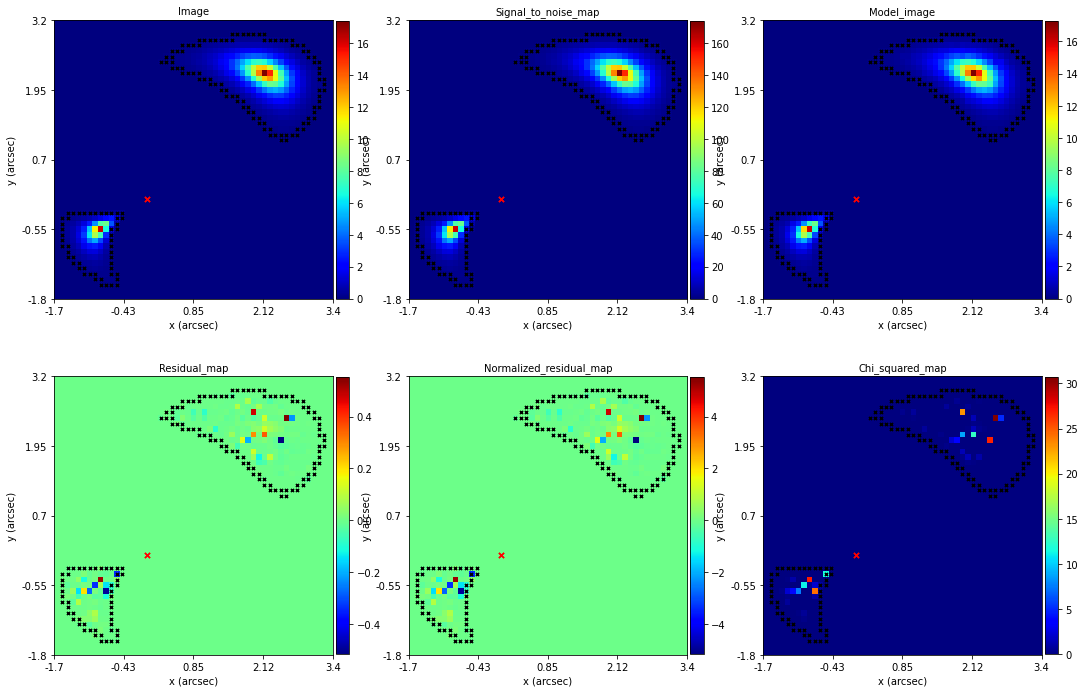

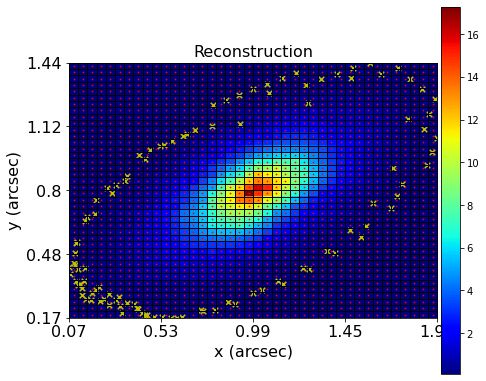

CPU times: user 5.74 s, sys: 82.8 ms, total: 5.82 s
Wall time: 6.19 s


169.12855074412118

In [4]:
# ml, kappa_s, qDM, log_mbh, mag_shear, phi_shear, gamma = pars
p0 = np.array([ml, kappa_, qobs_dm[0], np.log10(mbh), 0.02, 88., 1.0])
%time emcee_model(p0)

ParsDic:
#------------------------------------#
{'ml': 7.0, 'kappa_s': 0.1, 'qDM': 0.85, 'log_mbh': 9.0, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 0.8}


Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.1
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -121.46889168213659
Log Normalization -1317.2315249194833
Log Evidence: -944.7984098617345
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.8
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.1
scale_radius: 11.5
inner_slope: 1.0
z_l: 0.299
z_s: 4.1
critical_density: 2108482862924014.2
surf_lum: [18346.292692  5678.

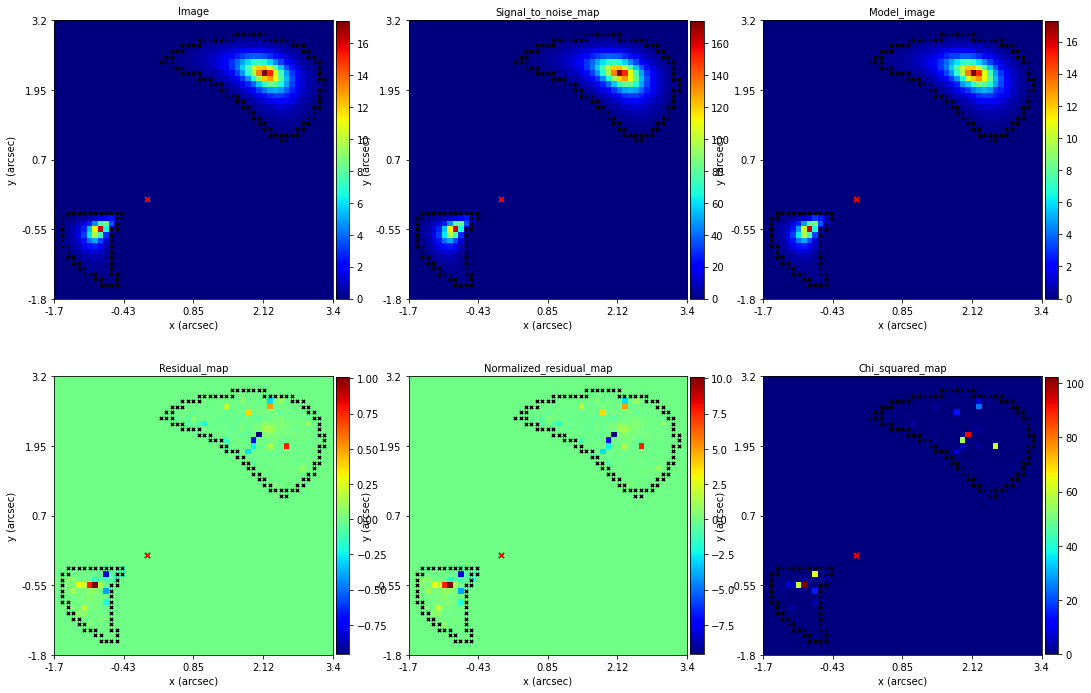

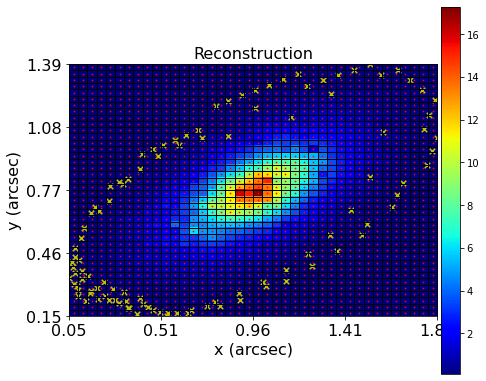

CPU times: user 2.27 s, sys: 47.7 ms, total: 2.32 s
Wall time: 2.28 s


-129.4688916821366

In [12]:
# ml, kappa_s, qDM, log_mbh, mag_shear, phi_shear, gamma = pars
p0 = np.array([ml, 0.1, qobs_dm[0], np.log10(mbh), 0.02, 88., 0.80])
%time emcee_model(p0)